In [1]:
path_to_weights = 'smoke_50-69.pth'

#### Imports

In [2]:
import os
import numpy as np
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
import cv2
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib.pyplot as plt

In [3]:
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


#### Load Model

In [4]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load(os.path.join(path_to_weights),map_location=device))
model.to(device)
print(device)

cuda


C:\Users\fjdes\AppData\Local\Temp\ipykernel_15672\2148199146.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(path_to_weight

In [6]:
color_smoke = np.array([128.0, 255.0, 128.0]) # BGR
color_fire = np.array([255.0, 128.0, 128.0]) # BGR
color_outline = np.array([0.0, 0.0, 0.0]) # BGR
color_inference = [color_outline, color_smoke, color_fire]

detection_threshold = 0.7

In [39]:
def run_model(image_path):
    model.eval()
    
    model_image = cv2.imread(image_path)
    model_image = cv2.cvtColor(model_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    model_image = model_image/255.0
    
    scale = model_image.shape[1]/model_image.shape[0]
    
    transform = A.Compose([
        A.Resize(height=600, width=int(scale*600), p=1.0),
        ToTensorV2()])
         
    model_image = transform(image=model_image)['image']
        
    cv2_image = np.transpose(model_image.numpy()*255,(1, 2, 0)).astype(np.float32)
    cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_RGB2BGR).astype(np.float32)
    
    # add batch dimension
    model_image = torch.unsqueeze(model_image, 0)
    with torch.no_grad():
        outputs = model(model_image.to(device))
        
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    
    # print(outputs[0])
    label_names = ["Background", "SMOKE", "FIRE"]
    
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = np.round(scores[scores >= detection_threshold],2)
        draw_boxes = boxes.copy()
    
    
        # Draw bounding box, labels, and confidence values
        for j,box in enumerate(draw_boxes):
            # Bounding Box (outline)
            cv2.rectangle(cv2_image,
                          (int(box[0]), int(box[1])),
                          (int(box[2]), int(box[3])),
                          color_outline, 2)

            # Bounding Box (outline)
            cv2.rectangle(cv2_image,
                          (int(box[0]), int(box[1])),
                          (int(box[2]), int(box[3])),
                          color_inference[outputs[0]['labels'][j]], 1)

            # Outline (label)
            cv2.putText(img=cv2_image, text=label_names[outputs[0]['labels'][j]],
                        org=(int(box[0] + 4), int(box[1] + 10)),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale= 0.3,color= color_outline,
                        thickness=2, lineType=cv2.LINE_AA)

            # Inner (label)
            cv2.putText(img=cv2_image, text=label_names[outputs[0]['labels'][j]],
                        org=(int(box[0] + 4), int(box[1] + 10)),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale= 0.3,color= color_inference[outputs[0]['labels'][j]],
                        thickness=1, lineType=cv2.LINE_AA)
            
            # Outline (confidence)
            cv2.putText(img=cv2_image, text=str(scores[j]),
                        org=(int(box[2] - 24), int(box[3] - 4)),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale= 0.3,color= color_outline,
                        thickness=2, lineType=cv2.LINE_AA)

            # Inner (confidence)
            cv2.putText(img=cv2_image, text=str(scores[j]),
                        org=(int(box[2] - 24), int(box[3] - 4)),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale= 0.3,color= color_inference[outputs[0]['labels'][j]],
                        thickness=1, lineType=cv2.LINE_AA)
    
        # set size
        plt.figure(figsize=(20,20))
        plt.axis("off")
    
        # convert color from CV2 BGR back to RGB
        plt_image = cv2.cvtColor(cv2_image/255.0, cv2.COLOR_BGR2RGB)
        plt.imshow(plt_image)
        plt.show()

#### Run Model

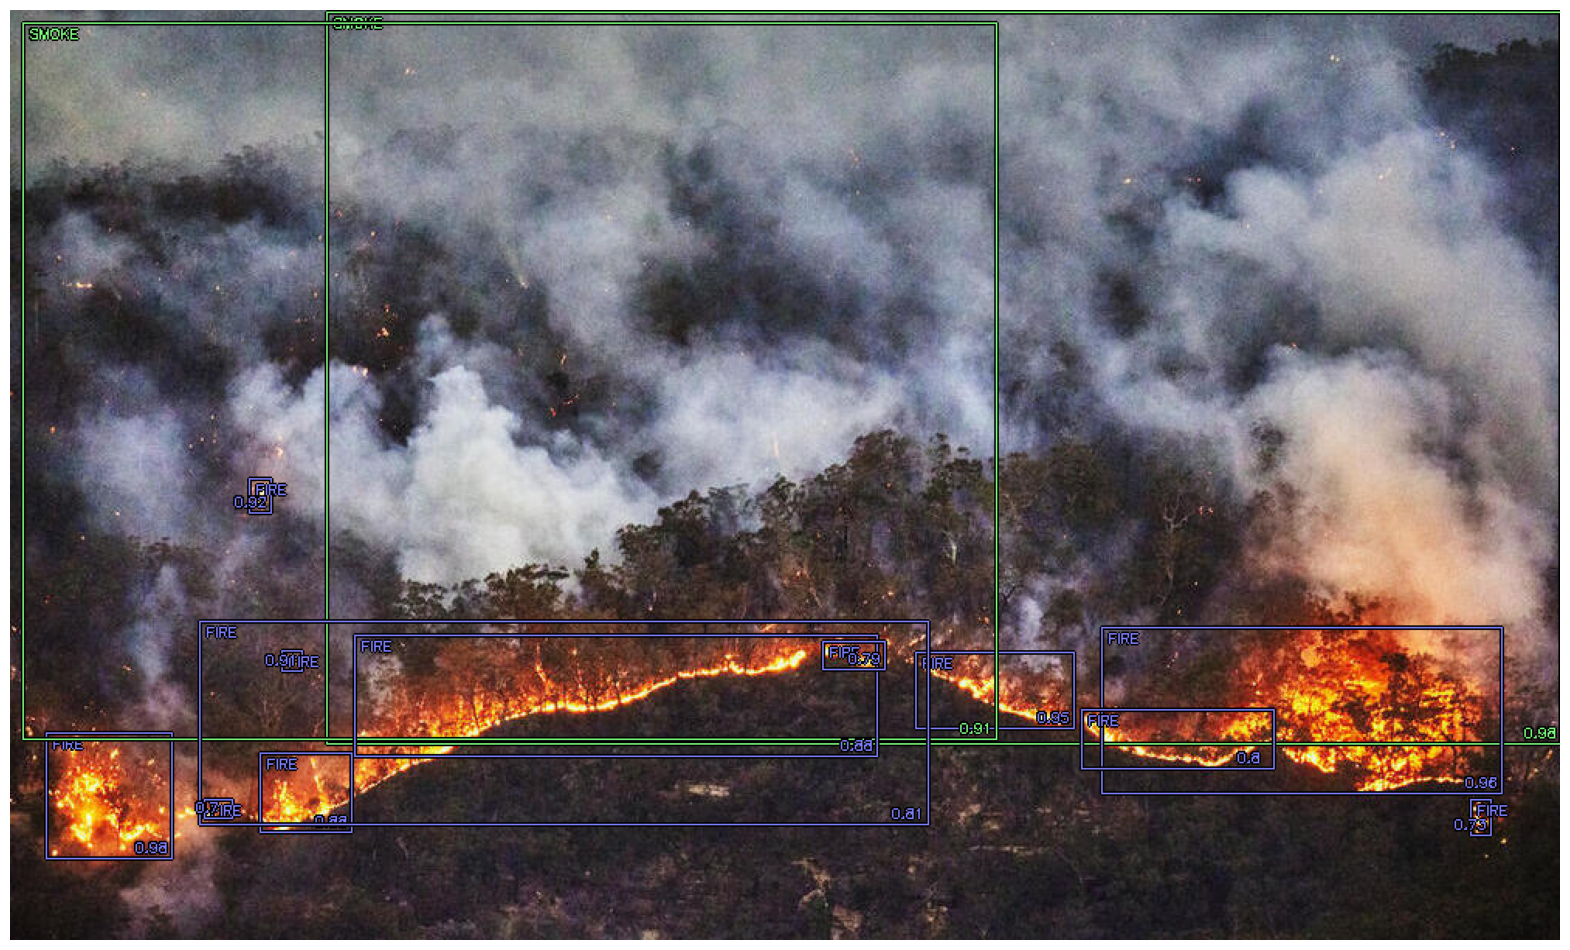

In [40]:
run_model('forest_fire.jpg')